# 有限差分离散Poisson方程
视频链接：https://www.bilibili.com/video/BV1QnVUzgEU3/?spm_id_from=333.337.search-card.all.click&vd_source=891137c33fd05c91613840a7ab4d0c6a

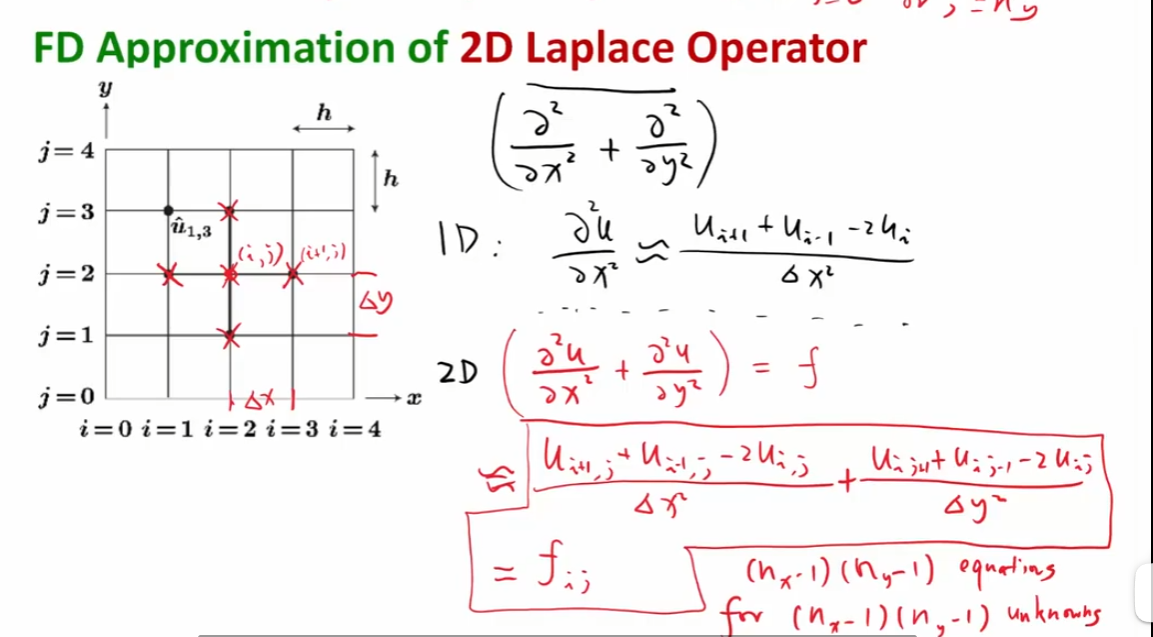

**这段代码使用 Taichi 编程语言实现了一个二维泊松方程 (Poisson's equation) 的求解器。它通过雅可比迭代法 (Jacobi method) 在一个 N x N 的网格上对该方程进行数值求解，并提供了实时可视化或性能基准测试的功能。**

---

### ## 🎯 主要功能
该程序旨在解决形如 `∇²x = b` 的二维泊松方程，这是物理和工程中一个非常基础的偏微分方程，常用于描述电势、引力场、热传导和流体压力等问题。

*   **x**: 未知的标量场（代码中的 `self.x`），是程序要求解的目标。
*   **b**: 已知的源项（代码中的 `self.b`）。
*   **∇²**: 拉普拉斯算子，代表场的二阶空间导数。

### ## ⚙️ 核心算法
程序采用了以下两种数值方法：

1.  **有限差分法 (Finite Difference Method)**
    *   将连续的二维空间离散化为一个 `N x N` 的网格。
    *   使用中心差分近似拉普拉斯算子：`∇²x ≈ (x[i+1,j] + x[i-1,j] + x[i,j+1] + x[i,j-1] - 4*x[i,j]) / dx²`。
    *   这样，偏微分方程就被转化成了一个大型线性方程组。

2.  **雅可比迭代法 (Jacobi Method)**
    *   这是一种经典的迭代算法，用于求解线性方程组。
    *   `substep` 内核中的核心更新公式正是雅可比法的体现：
        ```python
        self.xt[i,j] = (-self.b[i,j]*self.dx**2 + self.x[i+1,j] + self.x[i-1,j] + self.x[i,j+1] + self.x[i,j-1]) / 4.0
        ```
    *   在每次迭代中，它使用邻居节点的 **旧值** (`self.x`) 来计算当前节点的 **新值** (`self.xt`)。
    *   `while True` 循环不断执行这个迭代过程，使得解 `x` 逐步收敛到真实解。

### ## 📂 代码结构解析

*   `PoissonSolver` 类: 封装了求解器的所有状态和操作。
    *   `self.x`: 存储当前迭代的解。
    *   `self.b`: 存储源项 `b(x, y) = sin(πx) * sin(πy)`。
    *   `self.xt`: 一个临时缓存，用于存储下一次迭代的解，避免在同一步迭代中数据读写冲突。
*   `@ti.kernel`: Taichi 的装饰器，它会将修饰的 Python 函数编译成高性能的并行代码（在 CPU 或 GPU 上运行）。
*   `init()`: 初始化内核，将解 `x` 初始化为 0，并设置源项 `b` 的值。
*   `substep()`: 计算内核，执行单次雅可比迭代。
*   `main()`: 主函数，负责创建求解器实例，并在一个无限循环中不断调用 `step()` 来推进求解过程。
*   `argparse`: 命令行参数解析。允许用户在运行时指定网格大小 `N`、浮点数精度（`fp32` 或 `fp64`）以及运行模式。

In [1]:
import taichi as ti
import math
import time
import matplotlib.cm as cm
import numpy as np
import argparse

[Taichi] version 1.7.4, llvm 15.0.4, commit b4b956fd, linux, python 3.12.0


[I 09/21/25 19:40:17.420 127062] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [3]:
# parser = argparse.ArgumentParser(description='Taichi + MPI Poisson solver demo')
# parser.add_argument('-n', dest='N', type=int, default=1024)
# parser.add_argument('--fp32',  action='store_true')
# parser.add_argument('--benchmark', action='store_true')
# args = parser.parse_args()


命令行不适合直接使用，直接设置看看

In [4]:
show_gui = True
data_type = ti.f64
steps_interval = 1
N = 20

In [5]:
gui = ti.GUI('Poisson Solver', (N,N))

In [6]:
ti.init(arch=ti.cpu,default_fp=data_type, offline_cache=False, device_memory_GB=6)

[Taichi] Starting on arch=x64


**这是为了方便处理边界条件 (Boundary Conditions)。`N` 是内部计算区域的尺寸，`N+2` 的数组创建了“幽灵单元”(ghost cells) 或称为“光环”(halo) 的边界层，而 `N+1` 则用于正确计算网格间距。**

---

### ## 🎯 核心概念：边界条件与幽灵单元

在数值模拟中，尤其是使用有限差分法时，计算一个点的值通常需要它周围邻居点的信息。例如，本代码中的更新公式：
`xt[i,j] = (... + x[i-1,j] + x[i+1,j] + ...)`

如果 `i` 在计算区域的边缘（比如 `i=1`），那么它需要访问 `x[0,j]` 的值。这个 `x[0,j]` 就是边界。为了让计算内核不用写复杂的 `if/else` 来判断是否在边界，我们采用了一种高效的技巧：**幽灵单元 (Ghost Cells)**。

我们创建一个比实际计算区域(`N x N`)更大的数组(`(N+2) x (N+2)`)，多出来的外围一圈就是幽灵单元，专门用来存储固定的边界值。

### ## 🔢 N, N+1, N+2 的具体含义

#### 1. `N`: 内部计算网格 (The Active Grid)
*   这是你真正关心的、需要求解的离散区域的大小。
*   在代码中，主循环 `ti.ndrange((1, self.N+1), (1, self.N+1))` 遍历的正是 `i` 从 `1` 到 `N`、`j` 从 `1` 到 `N` 的所有点。这构成了一个 `N x N` 的核心计算区域。

#### 2. `N+2`: 包含边界的存储数组 (The Padded Array)
*   **这是最关键的一点**。为了给 `N x N` 的计算区域加上一圈边界，我们需要在每个维度的两边各增加一个单元。
*   所以，数组的尺寸是 `1 (左边界) + N (计算区) + 1 (右边界) = N+2`。
*   **可视化解释**:
    ```
      j=0   j=1   ...   j=N   j=N+1  <- 数组索引
    +-----+-----+-----+-----+-----+
    |  B  |  B  | ... |  B  |  B  | i=0   (B = Boundary/Ghost Cell)
    +-----+-----+-----+-----+-----+
    |  B  |  A  | ... |  A  |  B  | i=1   (A = Active Cell, N x N区域)
    +-----+-----+-----+-----+-----+
    | ... | ... | ... | ... | ... |
    +-----+-----+-----+-----+-----+
    |  B  |  A  | ... |  A  |  B  | i=N
    +-----+-----+-----+-----+-----+
    |  B  |  B  | ... |  B  |  B  | i=N+1
    +-----+-----+-----+-----+-----+
    ```
*   **优势**: 当计算 `i=1` 的点时，可以直接访问 `x[i-1]` 即 `x[0]`，而 `x[0]` 中已经预存了边界值（在这个例子中是0）。这使得计算内核非常简洁高效，无需处理边界的特殊情况。

#### 3. `N+1`: 网格间距的计算 (The Grid Spacing)
*   `dx` 代表网格点之间的物理距离。我们假设模拟的物理区域是一个边长为 1.0 的正方形。
*   你在这个 1.0 的长度内放置了 `N` 个内部点。这些点加上两端的边界点，共同将这个长度分成了 `N+1` 个相等的小段。
*   **一维示例 (N=3)**:
    `Boundary --- Point 1 --- Point 2 --- Point 3 --- Boundary`
    `   x=0         dx          dx          dx        dx   x=1`
    可以看到，3个内部点将长度为1的线段分成了 4 (`3+1`) 段。
*   因此，每段的长度 `dx` 就是总长度除以段数：`dx = 1.0 / (N + 1)`。

In [7]:
dx = 1.0/ (N +1)
# N+2是幽灵区吗
x = ti.field(dtype=data_type,shape = (N+2,N+2))
xt = ti.field(dtype=data_type,shape = (N+2,N+2))
b = ti.field(dtype=data_type,shape = (N+2,N+2))

In [10]:
@ti.kernel
def init(x: ti.template(), xt: ti.template(),b: ti.template(), N: ti.template()):
    for i in ti.grouped(x):
        x[i] = 0.0
        xt[i] = 0.0
    for i,j in b:
        xl = i / N
        yl = j / N
        b[i,j] = ti.sin(math.pi * xl) * ti.sin(math.pi * yl)

In [11]:
@ti.kernel
def substep(N:ti.template(), x:ti.template(), b:ti.template(), dx:ti.template(),xt:ti.template()):
    for i,j in ti.ndrange((1,N+1),(1,N+1)):
        xt[i,j] = (x[i+1,j]+x[i-1,j]+x[i,j+1]+x[i,j-1]-b[i,j]*dx**2)/4.0
    for i in ti.grouped(x):
        x[i]=xt[i]
    

In [12]:
def step(N:ti.template(), x:ti.template(), b:ti.template(), dx:ti.template(),xt:ti.template()):
    """
    迭代一次，计算一步
    """
    substep(N, x, b, dx,xt)
    ti.sync()

In [13]:
init(x,xt,b,N)

In [14]:
st =time.time()
while True:
    for i in range(50):
        step(N, x, b, dx,xt)
    et = time.time()
    if show_gui:
        x_np = x.to_numpy()
        ratio =2000
        x_img = cm.jet(abs(x_np[1:N+1, 1:N+1] * ratio))
        gui.set_image(x_img)
        gui.show()
    st = time.time()

KeyboardInterrupt: 